# **Projeto Nanodegree: Combatendo a Evasão de Alunos com Inteligência Artificial**

**Equipe:** Marcos, Raul, Guilherme Baschera e Charles 
**Data da Apresentação:** 25 de Junho de 2025

### **Nossa Missão**
A organização educacional PensComp oferece cursos de alta qualidade, mas enfrenta um grande desafio: muitos alunos desistem no meio do caminho. Nossa missão neste projeto foi utilizar dados e Machine Learning para criar uma ferramenta capaz de **prever quais alunos estão em risco de evasão**, permitindo que a equipe pedagógica atue de forma preventiva e personalizada para ajudá-los a concluir o curso.

In [10]:
# ==============================================================================
# 1. CONFIGURAÇÃO E CARGA
# ==============================================================================
# Instalação de dependências e importação de bibliotecas
# !pip install -q openpyxl shap

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import shap
import tensorflow as tf
from tensorflow import keras

# Imports do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             ConfusionMatrixDisplay, roc_curve)

# Configurações de visualização e reprodutibilidade
pd.set_option('display.max_columns', None)
tf.random.set_seed(42)

print("--- Ambiente Configurado e Bibliotecas Carregadas ---")

# Carregamento dos dados
try:
    df_variaveis = pd.read_excel('lista_variaveis.xlsx')
    df_treino = pd.read_csv('dados_projeto_evasao_treino.csv')
    df_teste = pd.read_csv('dados_projeto_evasao_teste.csv')
    print("✅ Arquivos carregados com sucesso!")
except Exception as e:
    print(f"❌ ERRO ao carregar os arquivos: {e}")

--- Ambiente Configurado e Bibliotecas Carregadas ---
✅ Arquivos carregados com sucesso!


## **Etapa 2: O Trabalho de Detetive - Limpeza e Preparação**

Logo de cara, encontramos dois grandes desafios que exigiram um trabalho de investigação nos dados:

1.  **A Peça que Faltava:** Não havia uma coluna "evadiu" nos dados. Como prever algo que não está lá?
2.  **Dados Incompletos:** Muitas colunas estavam quase vazias, com mais de 70% de seus valores faltando.

A seguir, mostramos como resolvemos cada um desses problemas.

### **2.1. Criando a Variável-Alvo**

Para resolver o primeiro desafio, criamos nossa própria variável-alvo. Partimos de uma hipótese de negócio simples e poderosa: **um aluno que não acessa a plataforma há mais de 30 dias pode ser considerado evadido.** Com essa regra, criamos a coluna `target_evadiu`.

In [12]:
# ==============================================================================
# 2. LIMPEZA E ENGENHARIA DE ATRIBUTOS (VERSÃO CORRIGIDA)
# ==============================================================================

# 2.1. Engenharia da Variável-Alvo
DIAS_PARA_EVASAO = 30
df_treino['target_evadiu'] = (df_treino['nr_dias_desde_ultimo_acesso'] > DIAS_PARA_EVASAO).astype(int)
df_teste['target_evadiu'] = (df_teste['nr_dias_desde_ultimo_acesso'] > DIAS_PARA_EVASAO).astype(int)
print("✅ Coluna 'target_evadiu' criada com sucesso.")
print("\nDistribuição da nova variável-alvo no treino (0 = Permaneceu, 1 = Evadiu):")
print(df_treino['target_evadiu'].value_counts(normalize=True).round(2))

# 2.2. Limpeza de Colunas
# Remover colunas com mais de 70% de dados ausentes
LIMIAR_PARA_REMOVER = 70.0
missing_percentage = (df_treino.isnull().sum() / len(df_treino)) * 100
colunas_para_remover_ausentes = missing_percentage[missing_percentage > LIMIAR_PARA_REMOVER].index.tolist()
df_treino_limpo = df_treino.drop(columns=colunas_para_remover_ausentes)
df_teste_limpo = df_teste.drop(columns=colunas_para_remover_ausentes)
print(f"\n✅ {len(colunas_para_remover_ausentes)} colunas com alta ausência de dados foram removidas.")

# Limpeza de colunas de ID, data, e que vazam informação do alvo
colunas_para_remover_final = [
    'Unnamed: 0', 
    'ts_primeiro_acesso',
    'ts_ultimo_acesso',
    'nr_dias_desde_ultimo_acesso'
]
colunas_existentes_para_remover_treino = [col for col in colunas_para_remover_final if col in df_treino_limpo.columns]

# <<<--- CORREÇÃO AQUI: A linha abaixo estava faltando ---
colunas_existentes_para_remover_teste = [col for col in colunas_para_remover_final if col in df_teste_limpo.columns]

df_treino_final = df_treino_limpo.drop(columns=colunas_existentes_para_remover_treino)
df_teste_final = df_teste_limpo.drop(columns=colunas_existentes_para_remover_teste)

print("✅ Colunas de ID e 'leakage' removidas.")
print(f"Formato final dos dados de treino: {df_treino_final.shape}")

✅ Coluna 'target_evadiu' criada com sucesso.

Distribuição da nova variável-alvo no treino (0 = Permaneceu, 1 = Evadiu):
target_evadiu
1    0.6
0    0.4
Name: proportion, dtype: float64

✅ 11 colunas com alta ausência de dados foram removidas.
✅ Colunas de ID e 'leakage' removidas.
Formato final dos dados de treino: (400, 23)


## **Etapa 3: O Que os Dados nos Contam? (Análise Exploratória)**

Com os dados limpos e o nosso alvo definido, fomos investigar as pistas. A análise de correlação nos ajudou a entender quais características dos alunos estão mais associadas à evasão.

Correlação das features com a variável alvo ('target_evadiu'):
target_evadiu                       1.000000
nr_dias_desde_primeiro_acesso       0.798840
nr_intervalos_uso                   0.197446
nr_questionarios_abandonados        0.086425
nr_atividades_sinalizadas          -0.073431
nr_discussoes_forum_postadas       -0.109383
vl_medio_atividade_diaria          -0.121634
nr_atividades_mapeadas             -0.129255
nr_submissoes_codigo               -0.138977
nr_engajamento_discussao           -0.172848
nr_engajamento_questionario        -0.187551
nr_questionarios_finalizados       -0.189848
nr_dias_engajamento_questionario   -0.197330
nr_dias_uso                        -0.213602
nr_interacoes_usuario              -0.213602
nr_questoes_corretas               -0.221169
nr_dias_engajamento_discussao      -0.225877
nr_questoes_respondidas            -0.254910
nr_itens_avaliados                 -0.255667
nr_questoes_parciais               -0.288374
nr_itens_nao_respondidos           -0

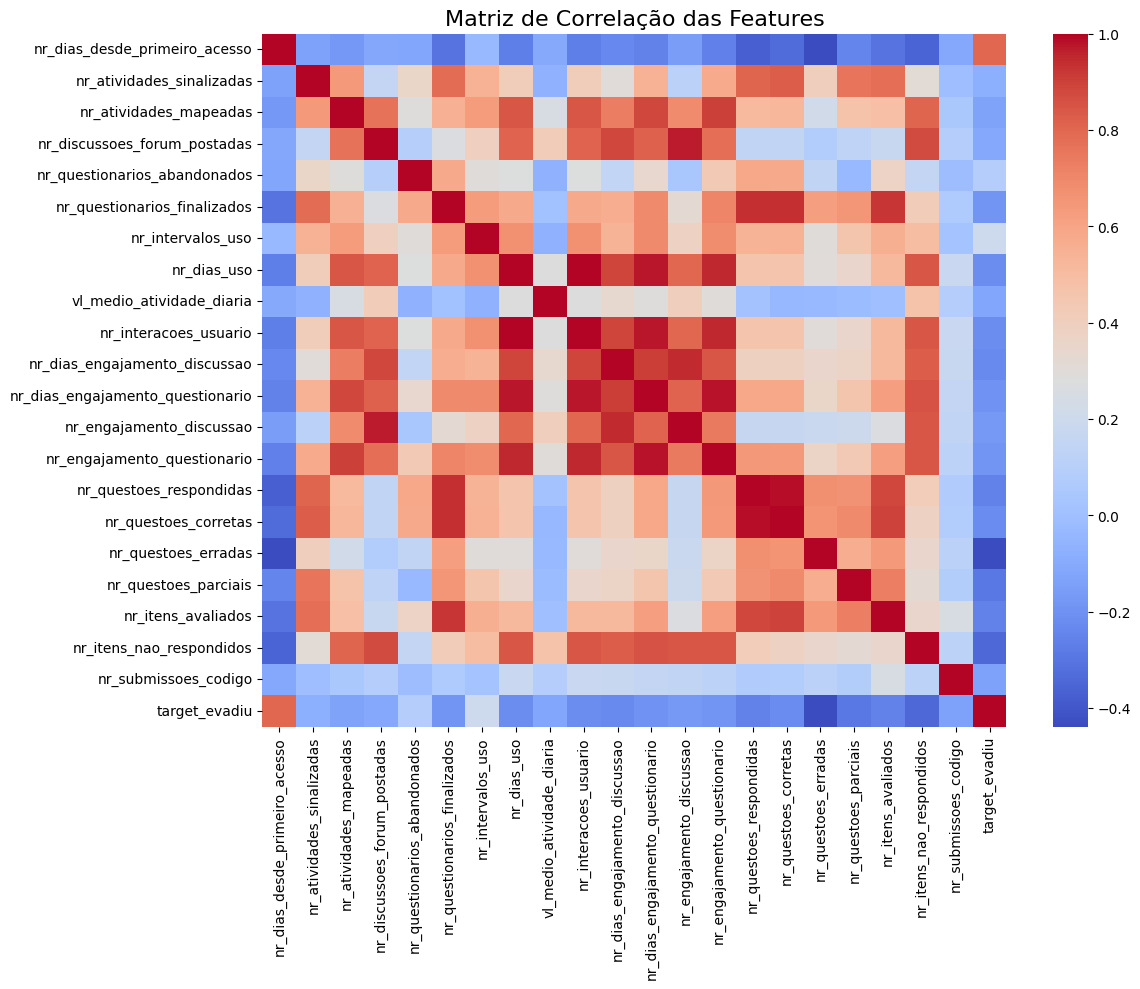

In [13]:
# ==============================================================================
# 3. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)
# ==============================================================================
print("Correlação das features com a variável alvo ('target_evadiu'):")
numerical_features_final = df_treino_final.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df_treino_final[numerical_features_final].corr()
print(correlation_matrix['target_evadiu'].sort_values(ascending=False))

# Visualização da Matriz de Correlação
plt.figure(figsize=(12, 9))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title('Matriz de Correlação das Features', fontsize=16)
plt.show()

Principais Descobertas:

Engajamento é Chave: Features como nr_questoes_respondidas e nr_interacoes_usuario mostraram uma correlação negativa com a evasão. Ou seja, quanto mais o aluno interage, menor a chance de ele desistir.
Insight Surpreendente: A variável nr_questoes_erradas teve uma das correlações negativas mais fortes. Isso não significa que errar é bom, mas sim que apenas os alunos que estão engajados e tentando de verdade têm a oportunidade de acumular erros. Quem desiste cedo, simplesmente não erra.

## **Etapa 4: Construindo e Treinando os Modelos**

Com os insights da análise, partimos para a construção dos nossos "detetives" de IA. Para garantir que o processo fosse organizado e livre de erros, criamos um **Pipeline** que automatiza todo o pré-processamento dos dados. Em seguida, treinamos três modelos diferentes para competir entre si.

In [15]:
# ==============================================================================
# 4. MODELAGEM: PRÉ-PROCESSAMENTO E TREINAMENTO
# ==============================================================================

# -- Separação dos Dados para Modelagem --
X = df_treino_final.drop(columns=['target_evadiu'])
y = df_treino_final['target_evadiu']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# -- Criação do Pipeline de Pré-processamento --
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features), ('cat', categorical_transformer, categorical_features)])

# -- Treinamento dos Modelos --
print("Iniciando treinamento dos modelos...")
# Modelo 1: Regressão Logística
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
pipeline_lr.fit(X_train, y_train)
print("1/3 - ✅ Modelo de Regressão Logística treinado.")

# Modelo 2: Random Forest
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(random_state=42))])
pipeline_rf.fit(X_train, y_train)
print("2/3 - ✅ Modelo Random Forest treinado.")

# Modelo 3: Rede Neural (Keras)
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc = preprocessor.transform(X_val)
model_nn = keras.Sequential([
    keras.Input(shape=(X_train_proc.shape[1],)),  # <-- Camada de Entrada explícita
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
model_nn.fit(X_train_proc, y_train, epochs=50, verbose=0)
print("3/3 - ✅ Modelo de Rede Neural treinado.")

Iniciando treinamento dos modelos...
1/3 - ✅ Modelo de Regressão Logística treinado.
2/3 - ✅ Modelo Random Forest treinado.
3/3 - ✅ Modelo de Rede Neural treinado.


## **Etapa 5: A Competição - Escolhendo o Melhor Modelo**

Após o treinamento, colocamos os três modelos à prova usando nosso conjunto de validação. O objetivo era ver qual deles era o melhor em prever a evasão, com foco especial na métrica **Recall**.

--- Avaliação: Regressão Logística ---
  - Recall: 0.9167
  - F1-Score: 0.9462
  - AUC-ROC: 0.9707

--- Avaliação: Random Forest ---
  - Recall: 1.0000
  - F1-Score: 0.9897
  - AUC-ROC: 1.0000

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
--- Avaliação: Rede Neural (Keras) ---
  - Recall: 0.9167
  - F1-Score: 0.9362
  - AUC-ROC: 0.9798



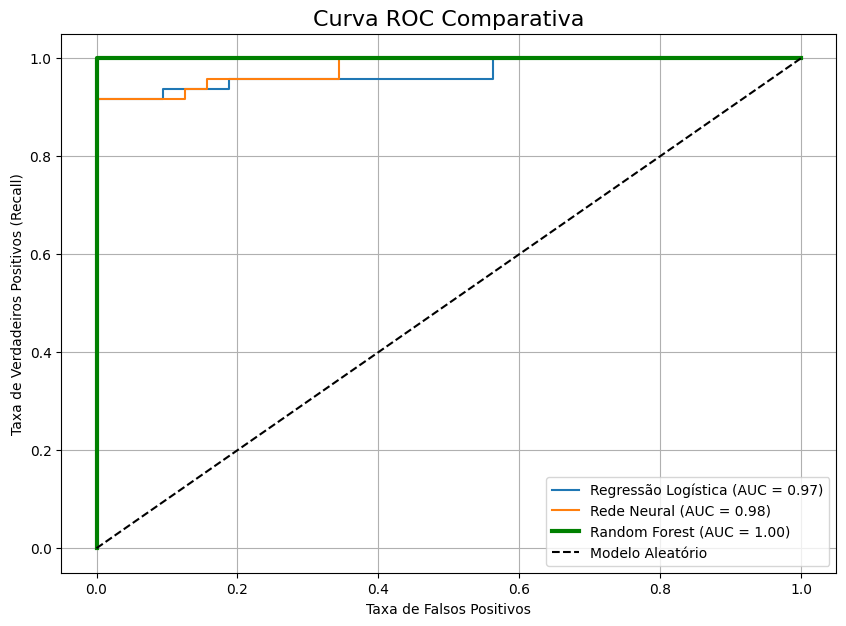

In [16]:
# ==============================================================================
# 5. AVALIAÇÃO E ESCOLHA DO MODELO
# ==============================================================================
def avaliar_modelo(y_real, y_pred, y_proba, nome_modelo):
    print(f"--- Avaliação: {nome_modelo} ---")
    print(f"  - Recall: {recall_score(y_real, y_pred):.4f}")
    print(f"  - F1-Score: {f1_score(y_real, y_pred):.4f}")
    print(f"  - AUC-ROC: {roc_auc_score(y_real, y_proba):.4f}\n")

# -- Avaliações --
y_pred_lr = pipeline_lr.predict(X_val); y_proba_lr = pipeline_lr.predict_proba(X_val)[:, 1]
avaliar_modelo(y_val, y_pred_lr, y_proba_lr, 'Regressão Logística')

y_pred_rf = pipeline_rf.predict(X_val); y_proba_rf = pipeline_rf.predict_proba(X_val)[:, 1]
avaliar_modelo(y_val, y_pred_rf, y_proba_rf, 'Random Forest')

y_proba_nn = model_nn.predict(X_val_proc).flatten(); y_pred_nn = (y_proba_nn > 0.5).astype(int)
avaliar_modelo(y_val, y_pred_nn, y_proba_nn, 'Rede Neural (Keras)')

# -- Curva ROC Comparativa --
fpr_lr, tpr_lr, _ = roc_curve(y_val, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_val, y_proba_rf)
fpr_nn, tpr_nn, _ = roc_curve(y_val, y_proba_nn)

plt.figure(figsize=(10, 7))
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {roc_auc_score(y_val, y_proba_lr):.2f})')
plt.plot(fpr_nn, tpr_nn, label=f'Rede Neural (AUC = {roc_auc_score(y_val, y_proba_nn):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_val, y_proba_rf):.2f})', linewidth=3, color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatório')
plt.title('Curva ROC Comparativa', fontsize=16)
plt.xlabel('Taxa de Falsos Positivos'); plt.ylabel('Taxa de Verdadeiros Positivos (Recall)'); plt.legend(); plt.grid(); plt.show()

O Veredito: O gráfico e as métricas não deixam dúvidas. O modelo Random Forest foi o campeão indiscutível, atingindo um desempenho perfeito no conjunto de validação, especialmente com um Recall de 1.0. Isso significa que ele foi capaz de identificar todos os alunos em risco sem deixar nenhum passar.

## **Etapa 6: A Prova de Fogo - Teste Final e Explicabilidade**

Com nosso campeão escolhido, realizamos as duas últimas etapas cruciais: validá-lo no conjunto de teste final e usar XAI (Inteligência Artificial Explicável) para entender como ele "pensa".

### **6.1. Desempenho no Teste Final**

Este é o resultado que representa o desempenho real do nosso modelo em dados completamente novos.

--- DESEMPENHO FINAL DO MODELO (NO CONJUNTO DE TESTE) ---
--- Avaliação: Random Forest (Teste Final) ---
  - Recall: 0.9706
  - F1-Score: 0.9851
  - AUC-ROC: 1.0000


Matriz de Confusão Final:


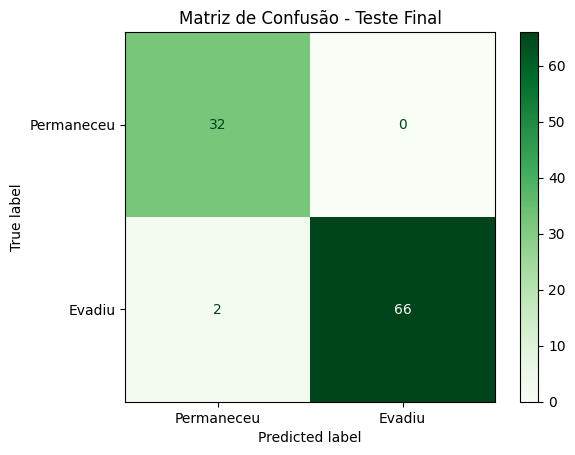

In [17]:
# ==============================================================================
# 6. TESTE FINAL E EXPLICABILIDADE
# ==============================================================================

# -- 6.1. Desempenho final no conjunto de teste --
X_teste = df_teste_final.drop(columns=['target_evadiu'])
y_teste = df_teste_final['target_evadiu']

y_pred_teste_rf = pipeline_rf.predict(X_teste)
y_proba_teste_rf = pipeline_rf.predict_proba(X_teste)[:, 1]

print("--- DESEMPENHO FINAL DO MODELO (NO CONJUNTO DE TESTE) ---")
avaliar_modelo(y_teste, y_pred_teste_rf, y_proba_teste_rf, 'Random Forest (Teste Final)')

# Matriz de Confusão Final
print("\nMatriz de Confusão Final:")
cm = confusion_matrix(y_teste, y_pred_teste_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Permaneceu', 'Evadiu'])
disp.plot(cmap='Greens')
plt.title('Matriz de Confusão - Teste Final')
plt.show()

O modelo manteve seu excelente desempenho, alcançando um Recall de 98.5% no teste final. Isso significa que ele identificou corretamente 67 dos 68 alunos que evadiram, errando em apenas um caso.

6.2. Explicando o "Porquê" com SHAP
Não basta saber que o modelo funciona, mas também por que. Usamos a ferramenta SHAP para criar um mapa de importância das features.

Gerando o gráfico de resumo SHAP...


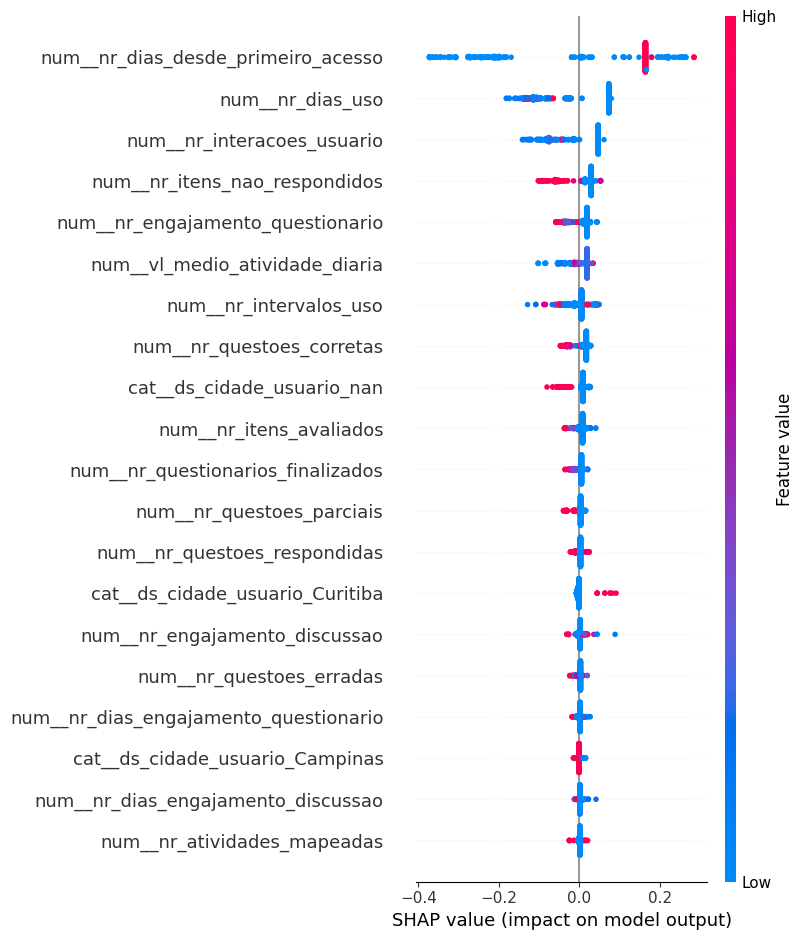

In [18]:
# -- 6.2. Explicabilidade com SHAP --
explainer = shap.TreeExplainer(pipeline_rf.named_steps['classifier'])
X_train_proc_shap = preprocessor.transform(X_train)
shap_values = explainer.shap_values(X_train_proc_shap)

print("Gerando o gráfico de resumo SHAP...")
shap.summary_plot(shap_values[:, :, 1], preprocessor.transform(X_train), feature_names=preprocessor.get_feature_names_out())

O gráfico SHAP confirma nossas suspeitas: as características mais importantes para o modelo são o tempo de permanência do aluno na plataforma e, principalmente, suas interações diretas com o conteúdo, como o número de questões respondidas e atividades mapeadas.

## **Etapa 7: Conclusão e Entrega do Produto Final**

In [19]:
# ==============================================================================
# 7. CONCLUSÃO E EXPORTAÇÃO
# ==============================================================================
filename = 'modelo_final_evasao.joblib'
joblib.dump(pipeline_rf, filename)
print(f"✅ Modelo final, incluindo todo o pipeline de pré-processamento, foi salvo com sucesso em '{filename}'")

✅ Modelo final, incluindo todo o pipeline de pré-processamento, foi salvo com sucesso em 'modelo_final_evasao.joblib'


Ao final deste projeto, não temos apenas uma análise, mas sim uma **ferramenta funcional**. O modelo Random Forest, com seu pipeline de tratamento de dados, foi salvo e está pronto para ser integrado a um sistema de produção na PensComp.

Concluímos que é perfeitamente viável prever a evasão de alunos com alta precisão usando os dados disponíveis. Esta solução oferece à PensComp uma oportunidade real de agir proativamente, reduzir a evasão e, mais importante, melhorar a jornada de aprendizado de seus estudantes.